### Data Preparation: Import Data from nespy

In [6]:
import pandas as pd
import numpy as np

# 从 numpy 数组中删除科学记数法
#安装 nsepy 库以获取股票价格

############################################
# 使用 nsepy 库获取 Stock 数据
from nsepy import get_history
from datetime import datetime

startDate=datetime(2013, 2,10)
endDate=datetime(2023, 2, 10)

# 获取数据
symbol = "INFY"
data=get_history(symbol=symbol, start=startDate, end=endDate)
print(data.shape)
data.head()

(2476, 14)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2013-02-11,INFY,EQ,2789.45,2801.25,2814.95,2784.90,2790.50,2792.05,2794.71,924349,2.583290e+14,39415,750516,0.8119
2013-02-12,INFY,EQ,2792.05,2770.00,2774.10,2741.75,2756.55,2755.25,2753.70,555299,1.529130e+14,45045,379010,0.6825
2013-02-13,INFY,EQ,2755.25,2757.00,2797.15,2745.00,2783.00,2789.55,2782.38,790361,2.199086e+14,38695,509982,0.6453
2013-02-14,INFY,EQ,2789.55,2794.40,2828.00,2794.35,2810.00,2812.75,2815.77,861750,2.426491e+14,54690,590742,0.6855
2013-02-15,INFY,EQ,2812.75,2790.00,2808.50,2776.30,2779.30,2788.60,2791.60,649282,1.812538e+14,46586,505981,0.7793


### Data Preparation: Load Data to SQL


In [11]:
import pymysql
from nsepy import get_history
from datetime import datetime

# Define the database connection parameters
host = 'localhost'
user = 'root'
password = '1234'
database = 'stock_data_db'

# Define the stock data retrieval parameters
symbol = 'INFY'
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 10, 5)

# Connect to the database
conn = pymysql.connect(host=host, user=user, password=password, database=database)
cursor = conn.cursor()

# Define the SQL query to create the table
create_table_query = """CREATE TABLE IF NOT EXISTS stock_data_all (
                        Symbol varchar(10),
                        Series varchar(10),
                        Date date,
                        Prev_Close float(15,2),
                        Open float(15,2),
                        High float(15,2),
                        Low float(15,2),
                        Last float(15,2),
                        Close float(15,2),
                        VWAP float(15,2),
                        Volume int(15),
                        Turnover float(20,2),
                        Trades int(15),
                        Deliverable_Volume int(15),
                        Percent_Deliverable float(15,2)
                        )"""

# Execute the SQL query to create the table
cursor.execute(create_table_query)

# Commit the changes to the database
conn.commit()

# Retrieve the stock data
data = get_history(symbol=symbol, start=start_date, end=end_date)

# Insert the stock data into the table
for index, row in data.iterrows():
    insert_query = f"""INSERT INTO stock_data_all (Symbol, Series, Date, Prev_Close, Open, High, Low, Last, Close, VWAP, Volume, Turnover, Trades, Deliverable_Volume, Percent_Deliverable)
                        VALUES ('{symbol}', '{row['Series']}', '{index}', {row['Prev Close']}, {row['Open']}, {row['High']}, {row['Low']}, {row['Last']}, {row['Close']}, {row['VWAP']}, {row['Volume']}, {row['Turnover']}, {row['Trades']}, {row['Deliverable Volume']}, {row['%Deliverble']})"""
    cursor.execute(insert_query)

# Commit the changes to the database
conn.commit()

# Close the database connection
conn.close()


In [11]:
import pymysql

conn = pymysql.connect(host="localhost", user="root", password="1234", database="stock_data_db")
cursor = conn.cursor()

create_table_sql = "CREATE TABLE stock_data (date DATE, symbol VARCHAR(10), open_price FLOAT, close_price FLOAT)"


cursor.execute(create_table_sql)

insert_sql = "INSERT INTO stock_data (date, symbol, open_price, close_price) VALUES (%s, %s, %s, %s)"
for index, row in data.iterrows():
    cursor.execute(insert_sql, (index, symbol, row['Open'], row['Close']))
    conn.commit()

select_sql = "SELECT * FROM stock_data"
cursor.execute(select_sql)

rows = cursor.fetchall()
for row in rows:
    print(row)

(datetime.date(2019, 1, 1), 'INFY', 660.95, 665.05)
(datetime.date(2019, 1, 2), 'INFY', 666.0, 669.05)
(datetime.date(2019, 1, 3), 'INFY', 672.0, 669.15)
(datetime.date(2019, 1, 4), 'INFY', 671.75, 661.05)
(datetime.date(2019, 1, 7), 'INFY', 665.0, 671.7)
(datetime.date(2019, 1, 8), 'INFY', 674.95, 670.05)
(datetime.date(2019, 1, 9), 'INFY', 686.2, 676.1)
(datetime.date(2019, 1, 10), 'INFY', 681.6, 679.7)
(datetime.date(2019, 1, 11), 'INFY', 680.2, 683.5)
(datetime.date(2019, 1, 14), 'INFY', 707.0, 701.9)
(datetime.date(2019, 1, 15), 'INFY', 707.2, 726.6)
(datetime.date(2019, 1, 16), 'INFY', 729.9, 736.8)
(datetime.date(2019, 1, 17), 'INFY', 735.8, 733.35)
(datetime.date(2019, 1, 18), 'INFY', 730.0, 730.95)
(datetime.date(2019, 1, 21), 'INFY', 738.2, 745.0)
(datetime.date(2019, 1, 22), 'INFY', 741.25, 745.35)
(datetime.date(2019, 1, 23), 'INFY', 742.35, 731.65)
(datetime.date(2019, 1, 24), 'INFY', 728.1, 732.0)
(datetime.date(2019, 1, 25), 'INFY', 728.0, 730.35)
(datetime.date(2019, 1,

### Data Preparation: Load Data from SQL to Pandas

In [13]:
query = "SELECT * FROM stock_data"
cursor.execute(query)

# Load the data into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Close the cursor and the connection
cursor.close()
conn.close()

C:\Users\SHU\AppData\Local\Temp\ipykernel_17704\3288214346.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [14]:
# Display the DataFrame
display(df)

,date,symbol,open_price,close_price
0,2019-01-01,INFY,660.95,665.05
1,2019-01-02,INFY,666.00,669.05
2,2019-01-03,INFY,672.00,669.15
3,2019-01-04,INFY,671.75,661.05
4,2019-01-07,INFY,665.00,671.70
...,...,...,...,...
431,2020-09-28,INFY,1014.80,1010.40
432,2020-09-29,INFY,1018.00,1009.00
433,2020-09-30,INFY,1009.00,1008.25
434,2020-10-01,INFY,1020.60,1017.65


In [15]:
StockData = df

<AxesSubplot: xlabel='date'>

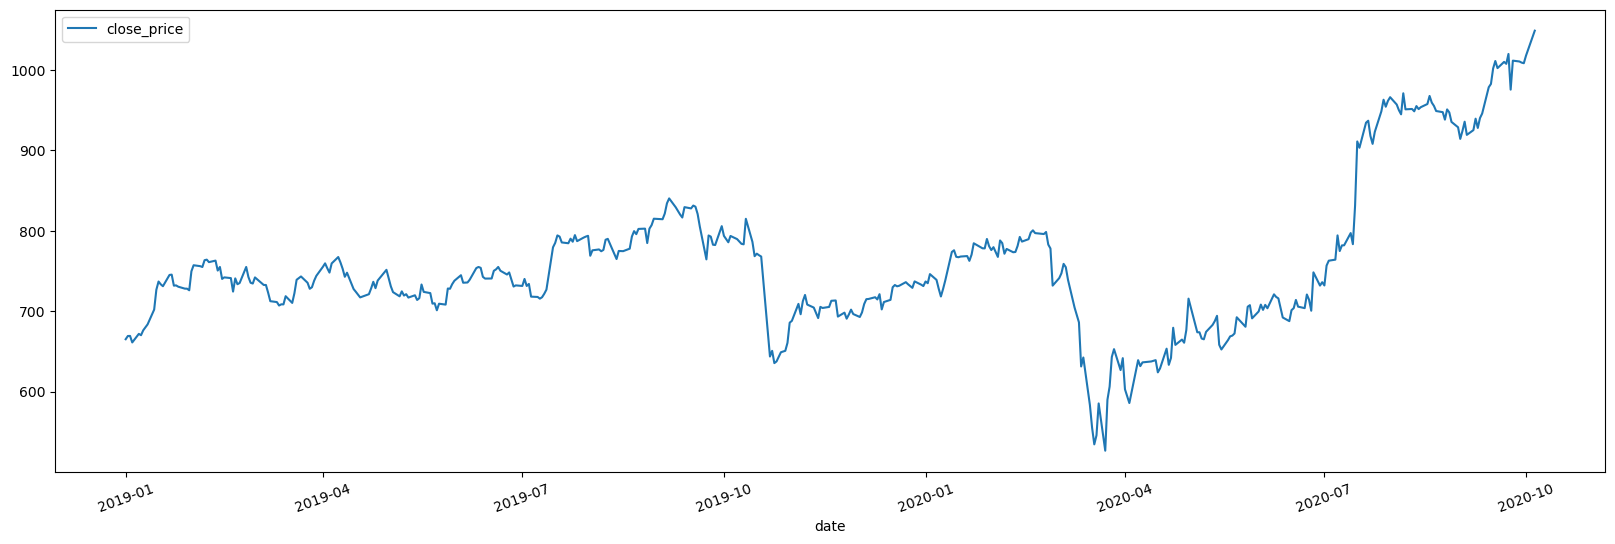

In [17]:
# 创建一个日期列
StockData['TradeDate']=StockData.index
import matplotlib

# 绘制股票价格
%matplotlib inline
StockData.plot(x='date', y='close_price', kind='line', figsize=(20,6), rot=20)

### Data Clean

In [20]:
# 提取每天的收盘价
FullData = StockData[['close_price']].values
print(FullData[0:5])

# 用于神经网络快速训练的特征缩放
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 在标准化或规范化之间进行选择
#sc = StandardScaler()
sc = MinMaxScaler()

DataScaler = sc.fit(FullData)
X = DataScaler.transform(FullData)
#X=FullData

print('### After Normalization ###')
X[0:5]

[[665.05]
 [669.05]
 [669.15]
 [661.05]
 [671.7 ]]
### After Normalization ###


array([[0.26539014],
       [0.27304931],
       [0.27324079],
       [0.25773097],
       [0.2781235 ]])

### Build Model: Prepare LSTM Model

In [22]:
### 准备LSTM
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps = 10  # 第二天的价格预测是基于过去多少天的价格

# 遍历值以创建组合
for i in range(TimeSteps, NumerOfRows, 1):
    x_sample = X[i - TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# 将输入重塑为 3D（样本数、时间步长、特征）
X_data = np.array(X_samples)
X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# 我们不会将 y 重塑为 3D 数据，因为它应该只是一列
y_data = np.array(y_samples)
y_data = y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)
### 将数据拆分为训练和测试
# 选择测试数据记录的数量
TestingRecords = 5

#将数据拆分为训练和测试
X_train = X_data[:-TestingRecords]
X_test = X_data[-TestingRecords:]
y_train = y_data[:-TestingRecords]
y_test = y_data[-TestingRecords:]

############################################

#打印训练和测试的形状
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)
### 可视化 LSTM 的输入和输出数据
# 可视化发送到 LSTM 模型的输入和输出
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp, '--', out)

# 为 LSTM 定义输入形状
TimeSteps = X_train.shape[1]
TotalFeatures = X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)


#### Input Data shape ####
(426, 10, 1)

#### Output Data shape ####
(426, 1)

#### Training Data shape ####
(421, 10, 1)
(421, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)
[[0.26539014]
 [0.27304931]
 [0.27324079]
 [0.25773097]
 [0.2781235 ]
 [0.2749641 ]
 [0.28654859]
 [0.29344184]
 [0.30071805]
 [0.33595022]] -- [0.38324557]
[[0.27304931]
 [0.27324079]
 [0.25773097]
 [0.2781235 ]
 [0.2749641 ]
 [0.28654859]
 [0.29344184]
 [0.30071805]
 [0.33595022]
 [0.38324557]] -- [0.40277645]
Number of TimeSteps: 10
Number of Features: 1


### Train

In [24]:
#导入 Keras 库和包
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#初始化RNN
regressor = Sequential()

# 添加第一个输入隐藏层和 LSTM 层
# return_sequences = True，表示每个时间步的输出要与隐藏的下一层共享
regressor.add(LSTM(units=10, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

# 添加 Second Second 隐藏层和 LSTM 层
regressor.add(LSTM(units=5, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

# 添加 Second Third 隐藏层和 LSTM 层
regressor.add(LSTM(units=5, activation='relu', return_sequences=False))

# 添加输出层
regressor.add(Dense(units=1))

# 编译 RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

##################################################

import time

# 测量模型训练所花费的时间
StartTime = time.time()

# 将 RNN 拟合到训练集
regressor.fit(X_train, y_train, batch_size=5, epochs=100)

EndTime = time.time()
print("## Total Time Taken: ", round((EndTime - StartTime) / 60), 'Minutes ##')

Epoch 1/100
85/85 [==============================] - 3s 4ms/step - loss: 0.1367
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 4/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 5/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 8/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 9/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 10/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 11/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 12/100
85/85 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 13/100
85/85 [=================

### Validate

1/1 [==============================] - 2s 2s/step
Accuracy: 98.68840694222993


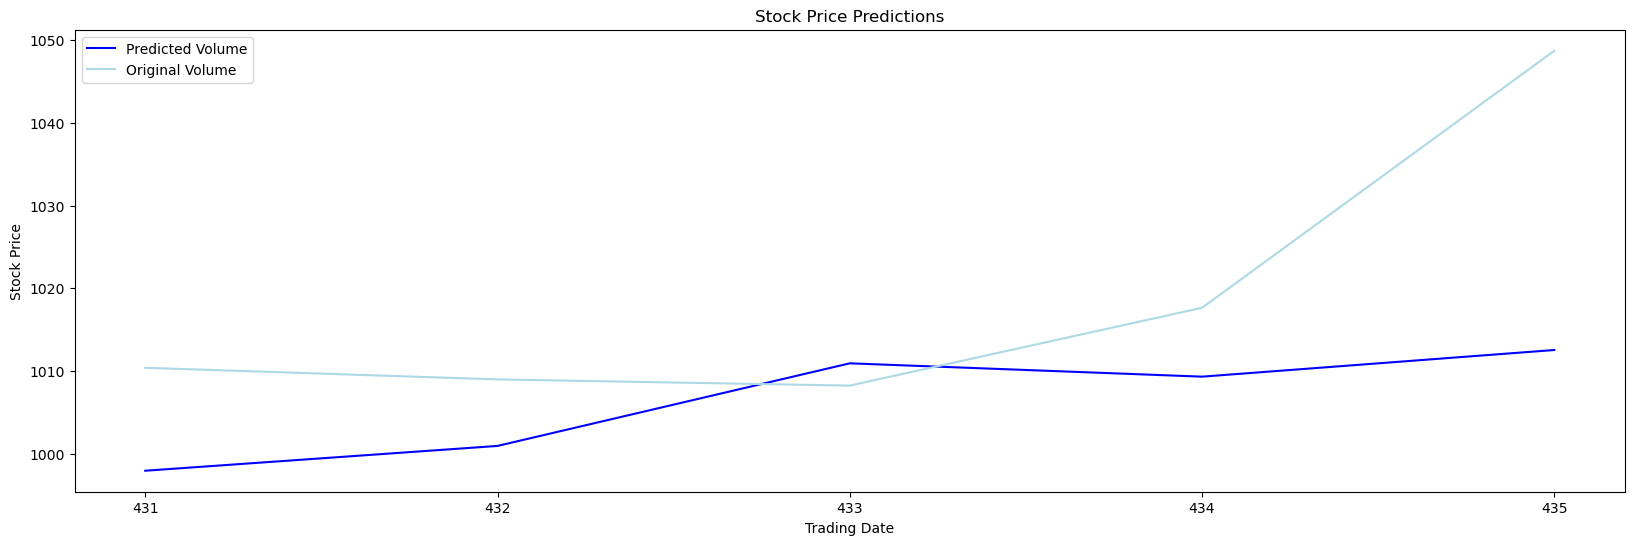

In [25]:
### 测量模型在测试数据上的准确性
# 对测试数据进行预测
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# 获取测试数据的原始价格值
orig = y_test
orig = DataScaler.inverse_transform(y_test)

# 预测的准确性
print('Accuracy:', 100 - (100 * (abs(orig - predicted_Price) / orig)).mean())

#可视化结果
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color='blue', label='Predicted Volume')
plt.plot(orig, color='lightblue', label='Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

### Visualization

1/1 [==============================] - 0s 16ms/step


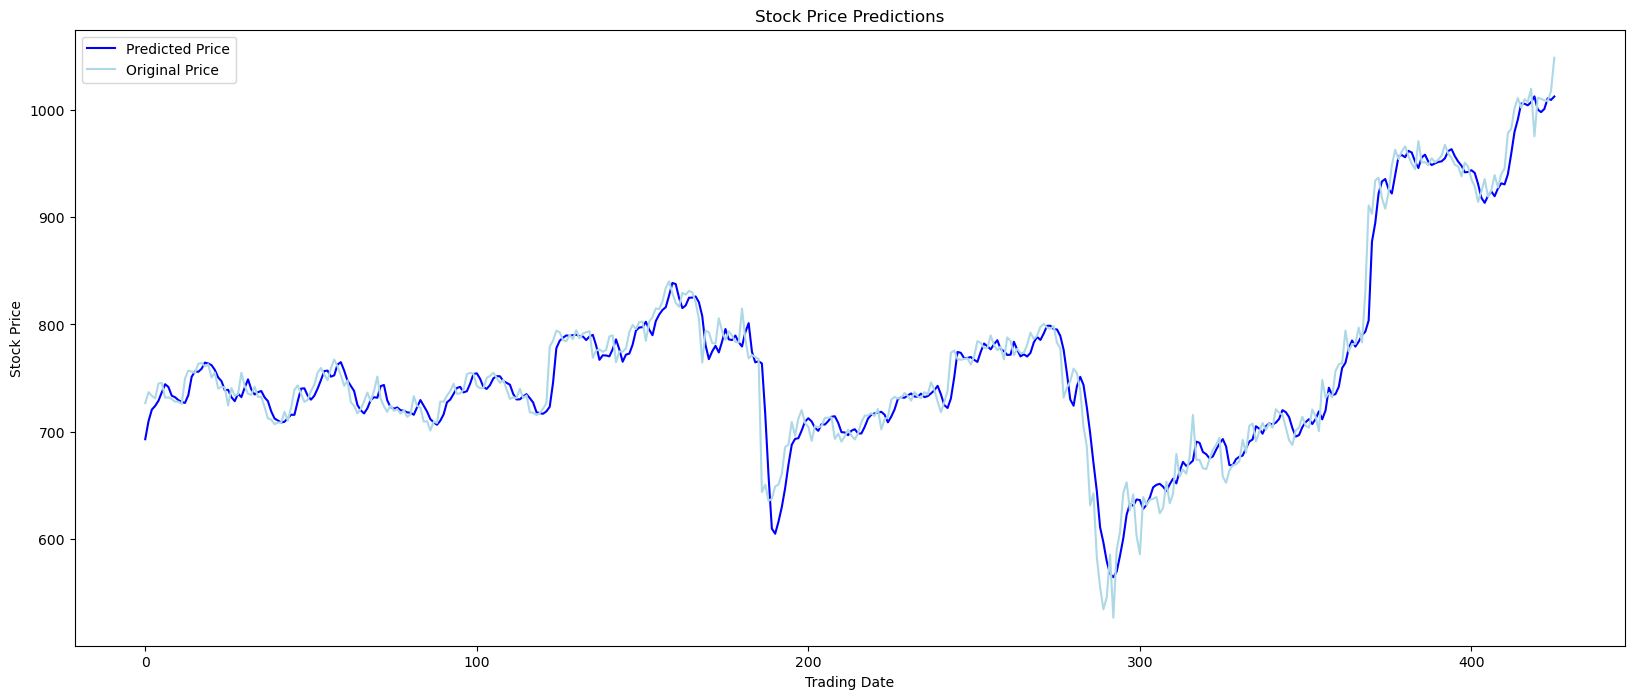

In [26]:
#对完整数据生成预测
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# 绘制完整数据
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()